# Language Models Lab Assignment
## Introduction to Language Models
Large Language Models (LLMs) like GPT-4, Claude, and LLaMA have revolutionized natural language processing. While these models have billions of parameters and are trained on vast datasets, they share fundamental architectural similarities with the model you'll build in this assignment. Most modern LLMs are based on decoder-only transformer architectures that generate text auto-regressively.

**Auto-regressive language modeling** means the model predicts the next token in a sequence based on all previous tokens. This approach allows the model to generate coherent text by repeatedly predicting and sampling new tokens, conditioned on the tokens it has already generated. The "language modeling" objective—predicting the next word given previous words—allows these models to learn syntax, semantics, factual knowledge, and even reasoning capabilities, all from the patterns in text.

In this assignment, you'll implement a word-level language model using the tiny Shakespeare dataset, which contains the complete works of William Shakespeare (~1MB of text). While small by modern standards, this dataset provides enough structure and patterns for our model to learn meaningful representations and generate Shakespeare-like text. The language, featuring archaic words and poetic structure, presents an interesting stylistic target for our model.
Through building this transformer-based architecture and training it to predict the next word in Shakespeare's texts, you'll gain insight into the core mechanisms that power today's most advanced language models—just at a much smaller scale.

In this assignment, you will build and train a word-level language model using PyTorch. You'll start by preprocessing text data, constructing a vocabulary, and encoding sentences into numerical representations. Using this processed data, you will implement key components of a transformer-based language model, including positional encoding, self-attention mechanisms, and feed-forward networks.

By the end, you will have hands-on experience with building and training neural language models, helping you understand how modern language models process and generate text.

## Part 1 : Data Preparation

In this section, you'll set up the data processing pipeline to transform raw text into a format suitable for training a language model.

In [1]:
import requests
import torch

# Example: Tiny Shakespeare (still somewhat weird for word-level, but let's demonstrate)
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text_data = requests.get(url).text

# 1. Split into words (naive approach)
words = text_data.split()
print("Number of words in dataset:", len(words))

# 2. Build the vocabulary from the set of unique words
unique_words = sorted(list(set(words)))
vocab_size = len(unique_words)
print("Vocabulary size:", vocab_size)


Number of words in dataset: 202651
Vocabulary size: 25670


The first step in building a language model is to process the raw text data. This includes tokenizing the text (splitting it into words) and building a vocabulary (the set of unique words in the dataset). For this assignment, we're using a simplified tokenization approach by splitting on whitespace.
The Shakespeare dataset contains approximately 200,000 words with a vocabulary of about 25,000 unique words. This rich vocabulary includes archaic terms, character names, and Shakespearean expressions that give the text its distinctive style. Our model will learn to predict the next word in this unique literary style, eventually generating text that mimics Shakespeare's writing patterns.

In [2]:
# Create two dictionaries - one to hold words to indices and another to hold indices to words
# word_to_idx = # TODO
# idx_to_word = # TODO

# your code here
word_to_idx = {word: idx for idx, word in enumerate(unique_words)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}


In [3]:
def test_word_mappings(student_word_to_idx, student_idx_to_word, unique_words):
    """
    Tests if the word-to-index and index-to-word mappings are correctly implemented.
    """
    # Check if dictionaries have correct size
    assert len(student_word_to_idx) == len(unique_words), f"word_to_idx should have {len(unique_words)} entries"
    assert len(student_idx_to_word) == len(unique_words), f"idx_to_word should have {len(unique_words)} entries"

    # Check if all words are mapped correctly
    for i, word in enumerate(sorted(unique_words)):
        assert word in student_word_to_idx, f"Word '{word}' is missing from word_to_idx"
        assert student_word_to_idx[word] == i, f"Word '{word}' should map to index {i}"
        assert i in student_idx_to_word, f"Index {i} is missing from idx_to_word"
        assert student_idx_to_word[i] == word, f"Index {i} should map to word '{word}'"

    # Check if mappings are inverses
    for word, idx in student_word_to_idx.items():
        assert student_idx_to_word[idx] == word, f"Mappings are not inverses for word '{word}'"

    print("✓ Word mappings test passed!")
    return True

test_word_mappings(word_to_idx, idx_to_word, unique_words)

✓ Word mappings test passed!


True

In [6]:
# Encode a sequence of words by converting them into indices 
def encode_word_sequence(seq):
    # TODO : Return a list of indices for the given sequence
    # your code here
    return [word_to_idx[word] for word in seq]

def decode_word_sequence(seq_ids):
    # TODO : Return a string given a list of indices
    # your code here
    return ' '.join([idx_to_word[idx] for idx in seq_ids])


In [7]:
def test_encoding_decoding_functions():
    """
    Test the implementation of encode_word_sequence and decode_word_sequence functions.
    Run this after defining word_to_idx and idx_to_word dictionaries.
    """
    # Test encoding
    print("Testing encode_word_sequence...")

    # Test with single word
    test_seq1 = ["the"]
    encoded1 = encode_word_sequence(test_seq1)
    assert isinstance(encoded1, list), "encode_word_sequence should return a list"
    assert len(encoded1) == 1, "Encoded sequence length should match input sequence length"
    assert encoded1[0] == word_to_idx["the"], f"Wrong index for 'the', expected {word_to_idx['the']}, got {encoded1[0]}"

    # Test with multiple words
    test_seq2 = ["to", "be", "or", "not", "to", "be"]
    encoded2 = encode_word_sequence(test_seq2)
    assert len(encoded2) == 6, "Encoded sequence length should match input sequence length"
    expected2 = [word_to_idx["to"], word_to_idx["be"], word_to_idx["or"],
                word_to_idx["not"], word_to_idx["to"], word_to_idx["be"]]
    assert encoded2 == expected2, f"Wrong encoding, expected {expected2}, got {encoded2}"

    # Test decoding
    print("Testing decode_word_sequence...")

    # Test with single index
    test_idx1 = [word_to_idx["the"]]
    decoded1 = decode_word_sequence(test_idx1)
    assert isinstance(decoded1, str), "decode_word_sequence should return a string"
    assert decoded1 == "the", f"Wrong decoding, expected 'the', got '{decoded1}'"

    # Test with multiple indices
    test_idx2 = [word_to_idx[w] for w in ["to", "be", "or", "not", "to", "be"]]
    decoded2 = decode_word_sequence(test_idx2)
    expected_str = "to be or not to be"
    assert decoded2 == expected_str, f"Wrong decoding, expected '{expected_str}', got '{decoded2}'"

    # Test round trip
    test_seq3 = ["shall", "I", "compare", "thee", "to", "a", "summer's", "day"]
    round_trip = decode_word_sequence(encode_word_sequence(test_seq3))
    expected_rt = "shall I compare thee to a summer's day"
    assert round_trip == expected_rt, f"Round trip failed, expected '{expected_rt}', got '{round_trip}'"

    print("All tests passed! The encoding and decoding functions are implemented correctly.")

test_encoding_decoding_functions()

Testing encode_word_sequence...
Testing decode_word_sequence...
All tests passed! The encoding and decoding functions are implemented correctly.


In [8]:
data = torch.tensor(encode_word_sequence(words), dtype=torch.long)
print("Encoded dataset size:", data.shape)

Encoded dataset size: torch.Size([202651])


We will use a simple data split for the purpose of this lab. The validation set will have 10% of the data. Normally, we would also want an external test set.

In [9]:
split_idx = int(0.9 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

## The Training Paradigm

An important aspect of autoregressive generative models is that they should be able to generate the next word given an initial sequence of words. When you type out a prompt in ChatGPT, you are giving it this initial sequence of words from which the model can begin generating text. To set this up correctly for training, we will use a block size of 32 and a batch size of 16. The block determines how many tokens are contained in a sequence and the batch determines the number of sequences to process at a time.

Let's use random starting positions and sample from the dataset repeatedly. Create two tensors 'x' and 'y'. 'x' is a set of words in the dataset that starts from a random index and contains the subsequent 32 tokens. 'y' is the same set shifted by one index. Each word in 'x' will have a shifted target value in 'y'. In other words, given an input token, the goal is to predict the next token in the sequence.

In [10]:
block_size = 32  # how many words per context
batch_size = 16  # sequences per batch

def get_batch(split='train'):
    dataset = train_data if split == 'train' else val_data
    # random starting positions
    idxs = torch.randint(len(dataset) - block_size - 1, (batch_size,))

    # TODO
    # x =
    # y =

    # your code here
    x = [dataset[i:i+block_size] for i in idxs]
    y = [dataset[i+1:i+1+block_size] for i in idxs]

    # Convert the lists to tensors by stacking them
    x = torch.stack(x)
    y = torch.stack(y)
    return x, y

xb, yb = get_batch('train')
print("x shape:", xb.shape, "y shape:", yb.shape)


x shape: torch.Size([16, 32]) y shape: torch.Size([16, 32])


In [11]:
def test_get_batch_function():
    """
    Test the implementation of get_batch function.
    Run this after defining block_size, batch_size, train_data, and val_data.
    """
    print("Testing get_batch function...")

    # Test with train data
    x_train, y_train = get_batch('train')

    # Check shapes
    assert x_train.shape == (batch_size, block_size), f"x_train shape should be ({batch_size}, {block_size}), got {x_train.shape}"
    assert y_train.shape == (batch_size, block_size), f"y_train shape should be ({batch_size}, {block_size}), got {y_train.shape}"

    # Check target is shifted by one position (next token prediction)
    for i in range(batch_size):
        assert torch.equal(x_train[i, 1:], y_train[i, :-1]), f"Target sequence should be shifted by one position for batch {i}"

    # Test with validation data
    x_val, y_val = get_batch('val')

    # Check shapes
    assert x_val.shape == (batch_size, block_size), f"x_val shape should be ({batch_size}, {block_size}), got {x_val.shape}"
    assert y_val.shape == (batch_size, block_size), f"y_val shape should be ({batch_size}, {block_size}), got {y_val.shape}"

    # Check target is shifted by one position (next token prediction)
    for i in range(batch_size):
        assert torch.equal(x_val[i, 1:], y_val[i, :-1]), f"Target sequence should be shifted by one position for batch {i}"

    # Check that using different splits gives different data
    # Note: This is probabilistic but highly likely with a large dataset
    assert not torch.equal(x_train, x_val), "Training and validation batches should be different"

    # Check that each batch sample starts at the position given by the random index
    # We need to recreate the random indices to verify this
    torch.manual_seed(0)  # Set seed for reproducibility
    idxs = torch.randint(len(train_data) - block_size - 1, (batch_size,))
    torch.manual_seed(0)  # Reset seed to get the same indices
    x_seeded, _ = get_batch('train')

    for i in range(batch_size):
        expected_start = train_data[idxs[i]]
        assert x_seeded[i, 0] == expected_start, f"Batch sample {i} should start with token at index {idxs[i]}"

    print("All tests passed! The get_batch function is implemented correctly.")

test_get_batch_function()

Testing get_batch function...
All tests passed! The get_batch function is implemented correctly.


In [12]:
# Let us now look at some examples from the dataset
example_batch = [decode_word_sequence(x.tolist()) for x in xb]
for i, ex in enumerate(example_batch):
    print(f"Example {i}: {ex}")
    print(f"Target {i}: {decode_word_sequence(yb[i].tolist())}\n")
    print("---------------")
    if i == 5:
        break

Example 0: I will with all expedient duty see you: For divers unknown reasons. I beseech you, Grant me this boon. LADY ANNE: With all my heart; and much it joys me too, To
Target 0: will with all expedient duty see you: For divers unknown reasons. I beseech you, Grant me this boon. LADY ANNE: With all my heart; and much it joys me too, To see

---------------
Example 1: well; To the hopeful execution do I leave you Of your commissions. ANGELO: Yet give leave, my lord, That we may bring you something on the way. DUKE VINCENTIO: My haste may
Target 1: To the hopeful execution do I leave you Of your commissions. ANGELO: Yet give leave, my lord, That we may bring you something on the way. DUKE VINCENTIO: My haste may not

---------------
Example 2: your honour will command?' Let one attend him with a silver basin Full of rose-water and bestrew'd with flowers, Another bear the ewer, the third a diaper, And say 'Will't please your
Target 2: honour will command?' Let one attend him with a sil

# Implementing the Self-Attention Mechanism

The Head class implements a self-attention mechanism that allows the model to focus on different parts of the input sequence when making predictions. The "causal" part means it only allows a token to attend to itself and previous tokens (not future ones), which is essential for autoregressive language modeling.

1. **Contextual Understanding**: The attention mechanism lets the model relate different positions in a sequence, capturing dependencies between words regardless of their distance.
2. **Parallel Processing**: Unlike RNNs, transformers process all tokens in parallel, making them much faster to train.
3. **Causal Masking**: The triangular mask ensures the model only looks at past tokens when predicting the next one, which is essential for autoregressive generation.
4. **Flexible Focus**: Each token can "pay attention" to relevant parts of the input sequence, rather than treating all context equally.
5. **Scaling Dot-Product**: The scaled dot-product attention mechanism is efficient and helps stabilize training by preventing extremely large values.

In [13]:
import torch
import torch.nn as nn
import math

class Head(nn.Module):
    def __init__(self, head_size, embed_dim, block_size, dropout=0.1):
        super().__init__()

        # Linear projection for keys : transforms embeddings to attention space
        self.key = nn.Linear(embed_dim, head_size, bias=False)

        # self.query =
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        # self.value =
        self.value = nn.Linear(embed_dim, head_size, bias=False)

        # your code here
        # ✅ Nothing else needed here

        # Create a lower triangular matrix for causal masking (each token can only attend to itself and previous tokens)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Get dimensions: Batch size, Sequence length, Embedding dimension
        B, T, C = x.shape # shape: (B, T, head_size)

        # Project input embeddings to key space
        k = self.key(x) # shape: (B, T, head_size)

        # Project input embeddings to query space
        q = self.query(x) # shape: (B, T, head_size)

        # Compute attention scores: dot product of queries and keys, scaled by sqrt(head dimension)
        # The scaling prevents values from exploding when dimension is large
        weights = q @ k.transpose(-2, -1) / math.sqrt(C)

        # Apply causal mask: ensure tokens can only attend to previous tokens (and themselves)
        mask = self.tril[:T, :T] # Get appropriate sized mask for current sequence length
        weights = weights.masked_fill(mask == 0, float('-inf')) # Set masked positions to -infinity

        # Apply softmax to get attention probabilities
        att = torch.softmax(weights, dim=-1) # shape: (B, T, T)
        att = self.dropout(att)

        # Project input embeddings to value space
        v = self.value(x) # shape: (B, T, head_size)

        # Compute weighted sum of values based on attention weights
        out = att @ v # shape: (B, T, head_size)
        return out


In [14]:
def test_head_implementation():
    """
    Test the implementation of the attention head.
    This test verifies that students have correctly implemented the query and value projections.
    """
    print("Testing Head class implementation...")

    # Set up test parameters
    head_size = 8
    embed_dim = 16
    block_size = 10
    batch_size = 4
    seq_len = 6

    # Create a test input tensor
    x = torch.randn(batch_size, seq_len, embed_dim)

    # Initialize the head
    head = Head(head_size, embed_dim, block_size)

    # Check that query and value projections exist
    assert hasattr(head, 'query'), "Head class missing 'query' attribute"
    assert hasattr(head, 'value'), "Head class missing 'value' attribute"

    # Check that they are nn.Linear instances
    assert isinstance(head.query, nn.Linear), "'query' should be an instance of nn.Linear"
    assert isinstance(head.value, nn.Linear), "'value' should be an instance of nn.Linear"

    # Check the shapes of the weight matrices
    assert head.query.weight.shape == (head_size, embed_dim), f"Query weight matrix should be shape ({head_size}, {embed_dim})"
    assert head.value.weight.shape == (head_size, embed_dim), f"Value weight matrix should be shape ({head_size}, {embed_dim})"

    # Check that bias is False
    assert head.query.bias is None, "Query projection should have bias=False"
    assert head.value.bias is None, "Value projection should have bias=False"

    # Test forward pass
    try:
        output = head(x)
        assert output.shape == (batch_size, seq_len, head_size), f"Output shape should be ({batch_size}, {seq_len}, {head_size})"

        # Extra verification: ensure forward pass uses the query and value projections
        # We can do this by temporarily replacing them with dummy functions that raise exceptions
        original_query = head.query
        original_value = head.value

        # Create dummy functions
        class DummyModule(nn.Module):
            def forward(self, x):
                raise RuntimeError("This method should be called")

        # Test query projection is used
        try:
            head.query = DummyModule()
            try:
                head(x)
                assert False, "Forward pass didn't use query projection"
            except RuntimeError:
                pass  # Expected error
        finally:
            head.query = original_query

        # Test value projection is used
        try:
            head.value = DummyModule()
            try:
                head(x)
                assert False, "Forward pass didn't use value projection"
            except RuntimeError:
                pass  # Expected error
        finally:
            head.value = original_value

    except Exception as e:
        assert False, f"Forward pass failed: {str(e)}"

    print("All tests passed! The Head class is implemented correctly.")

test_head_implementation()

Testing Head class implementation...
All tests passed! The Head class is implemented correctly.


Now that we have defined a single attnetion head, let's make a class for multi-head attention. Let's also define a simple feedforward class. You don't have to modify any of this code. Read through it to understand what is going on.

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embed_dim, block_size, dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList(
            [Head(head_size, embed_dim, block_size, dropout) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(num_heads * head_size, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [16]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffw_hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, ffw_hidden_dim),
            nn.ReLU(),
            nn.Linear(ffw_hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# The Transformer Block

The TransformerBlock class encapsulates the core structure found in transformer models: a multi-head attention layer followed by a feed-forward network, each preceded by layer normalization and accompanied by residual connections. This architecture allows for effective processing of sequential data by combining the contextual awareness of attention with the representational power of feed-forward networks.

In [17]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, block_size, ffw_hidden_dim, dropout=0.1):
        super().__init__()

        # Calculate the size of each attention head
        head_size = embed_dim // num_heads

        # Layer normalization before the attention block
        # Helps stabilize and accelerate training by normalizing inputs
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(num_heads, head_size, embed_dim, block_size, dropout)
        self.ffw = FeedForward(embed_dim, ffw_hidden_dim, dropout)

    def forward(self, x):
        # Residual connection around the attention block
        # First normalize the input, then apply attention, then add back the original input
        x = x + self.attn(self.ln1(x))

        # Residual connection around the feed-forward block
        # First normalize the input, then apply feed-forward, then add back the intermediate result
        x = x + self.ffw(self.ln2(x))
        return x

# Understanding a Basic GPT Language Model Architecture

The GPT class defines the entire architecture of the language model. It combines token embeddings, positional embeddings, multiple transformer blocks, and a final projection layer to create a generative model that predicts the next token in a sequence. It also includes a text generation method that can produce new content autoregressively.

1. **Complete Language Model**: This class brings together all components needed for a generative language model - embeddings, attention, transformations, and prediction.
2. **Positional Information**: Since transformers process all tokens in parallel, the positional embeddings are crucial to retain sequence order information.
3. **Multi-Layer Processing**: The stacked transformer blocks allow the model to learn increasingly abstract representations of the text.
4. **Training and Generation**: The class handles both the training process (via the loss calculation) and the generation process (via the generate method).
5. **Autoregressive Generation**: The generate method implements autoregressive text generation - each new token is based on all previously generated tokens.
6. **Context Management**: The model handles context length limitations by truncating inputs to the maximum block size when needed.
7. **Token Sampling**: Rather than always selecting the most probable next token, the model samples from the probability distribution, leading to more diverse text generation.

This GPT architecture has become the foundation for many state-of-the-art language models. Its ability to learn from large corpora of text and generate coherent, contextually relevant content has led to its widespread adoption in many natural language processing applications, from chatbots to content creation tools.

In [22]:
import torch
import torch.nn as nn

class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, n_layers, num_heads, ffw_hidden_dim, dropout=0.1):
        super().__init__()
        self.block_size = block_size

        # Embedding layer that converts token IDs to vectors
        self.token_embed = nn.Embedding(vocab_size, embed_dim)

        # Embedding layer that provides position information
        self.pos_embed = nn.Embedding(block_size, embed_dim)

        # Create a stack of transformer blocks
        transformer_blocks = []

        # Create each transformer block individually and add it to the list
        for _ in range(n_layers):
            transformer_blocks.append(
                TransformerBlock(embed_dim, num_heads, block_size, ffw_hidden_dim, dropout)
            )

        # Create the sequential container with all blocks
        self.blocks = nn.Sequential(*transformer_blocks)
        self.ln_f = nn.LayerNorm(embed_dim)  # final layer norm

        # Output projection that converts embeddings back to vocabulary logits
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # (1) token + positional embeddings
        tok_emb = self.token_embed(idx)  # shape: (B, T, embed_dim)
        pos_emb = self.pos_embed(torch.arange(T, device=idx.device))  # shape: (T, embed_dim)
        x = tok_emb + pos_emb.unsqueeze(0)  # shape: (B, T, embed_dim)

        # (2) Pass the embeddings through the transformer blocks
        x = self.blocks(x)  # shape: (B, T, embed_dim)

        # (3) Apply final normalization and project to vocabulary logits
        x = self.ln_f(x)  # shape: (B, T, embed_dim)
        logits = self.head(x)  # shape: (B, T, vocab_size)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits_2d = logits.view(B * T, C)
            targets_2d = targets.view(B * T)
            loss = nn.CrossEntropyLoss()(logits_2d, targets_2d)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx[:, -self.block_size:]

            # Forward pass to get next token probabilities
            logits, _ = self(idx_cond)

            # We only need predictions for the last token in the sequence
            logits = logits[:, -1, :]  # shape (B, vocab_size)

            # Convert logits to probabilities using softmax
            probs = torch.softmax(logits, dim=-1)

            # Sample from the probability distribution
            next_idx = torch.multinomial(probs, num_samples=1)

            # Append the new token to the sequence
            idx = torch.cat((idx, next_idx), dim=1)
        return idx


In [23]:
def test_gpt_implementation():
    """
    Test the implementation of the GPT class.
    This test verifies that students have correctly implemented the missing components.
    """
    print("Testing GPT class implementation...")

    # Set up test parameters
    vocab_size = 100
    embed_dim = 32
    block_size = 10
    n_layers = 2
    num_heads = 4
    ffw_hidden_dim = 64

    # Create a small test input
    batch_size = 2
    seq_len = 8
    idx = torch.randint(0, vocab_size, (batch_size, seq_len))
    targets = torch.randint(0, vocab_size, (batch_size, seq_len))

    # Test the GPT initialization
    model = GPT(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        block_size=block_size,
        n_layers=n_layers,
        num_heads=num_heads,
        ffw_hidden_dim=ffw_hidden_dim
    )

    # 1. Test token and position embeddings
    assert hasattr(model, 'token_embed'), "GPT class missing 'token_embed' attribute"
    assert hasattr(model, 'pos_embed'), "GPT class missing 'pos_embed' attribute"

    assert isinstance(model.token_embed, nn.Embedding), "'token_embed' should be an instance of nn.Embedding"
    assert isinstance(model.pos_embed, nn.Embedding), "'pos_embed' should be an instance of nn.Embedding"

    assert model.token_embed.weight.shape == (vocab_size, embed_dim), f"Token embedding weight should be shape ({vocab_size}, {embed_dim})"
    assert model.pos_embed.weight.shape == (block_size, embed_dim), f"Position embedding weight should be shape ({block_size}, {embed_dim})"

    # 2. Test transformer blocks
    assert hasattr(model, 'blocks'), "GPT class missing 'blocks' attribute"
    assert isinstance(model.blocks, nn.Sequential), "'blocks' should be an instance of nn.Sequential"
    assert len(model.blocks) == n_layers, f"There should be {n_layers} transformer blocks"

    # Check that each block is a TransformerBlock
    for i, block in enumerate(model.blocks):
        assert isinstance(block, TransformerBlock), f"Block {i} should be a TransformerBlock"

    # 3. Test forward pass
    try:
        logits, loss = model(idx, targets)
        assert logits.shape == (batch_size, seq_len, vocab_size), f"Logits shape should be ({batch_size}, {seq_len}, {vocab_size})"
        assert isinstance(loss, torch.Tensor), "Loss should be a scalar torch.Tensor"
    except Exception as e:
        assert False, f"Forward pass failed: {str(e)}"

    # 4. Test generation method components directly

    # Test idx_cond truncation
    try:
        # Create a test method that only tests the idx_cond part
        def test_idx_cond():
            long_context = torch.randint(0, vocab_size, (1, block_size + 5))
            model.block_size = block_size  # Ensure block_size is set

            # Get the idx_cond by running just that part of the code
            idx_cond = long_context[:, -block_size:]

            # Verify it was truncated correctly
            assert idx_cond.shape[1] == block_size, "idx_cond should be truncated to block_size"
            assert torch.equal(idx_cond, long_context[:, -block_size:]), "idx_cond should contain the last block_size tokens"

            print("✓ idx_cond implementation is correct")

        test_idx_cond()
    except Exception as e:
        assert False, f"idx_cond implementation test failed: {str(e)}"

    # Test last token logits selection
    try:
        # Create dummy logits tensor
        dummy_logits = torch.randn(batch_size, seq_len, vocab_size)

        # Extract last token logits
        last_token_logits = dummy_logits[:, -1, :]

        # Verify shape
        assert last_token_logits.shape == (batch_size, vocab_size), "Last token logits should have shape (batch_size, vocab_size)"

        # Verify content
        assert torch.equal(last_token_logits, dummy_logits[:, -1, :]), "Last token logits should be extracted correctly"

        print("✓ Last token logits extraction is correct")
    except Exception as e:
        assert False, f"Last token logits test failed: {str(e)}"

    # Test softmax application
    try:
        # Create dummy logits
        dummy_logits = torch.randn(batch_size, vocab_size)

        # Apply softmax
        probs = torch.softmax(dummy_logits, dim=-1)

        # Verify shape
        assert probs.shape == (batch_size, vocab_size), "Probability distribution should have same shape as input logits"

        # Verify it's a valid probability distribution
        assert torch.allclose(probs.sum(dim=-1), torch.ones(batch_size)), "Probabilities should sum to 1 along vocabulary dimension"
        assert (probs >= 0).all() and (probs <= 1).all(), "Probabilities should be between 0 and 1"

        print("✓ Softmax application is correct")
    except Exception as e:
        assert False, f"Softmax test failed: {str(e)}"

    print("All tests passed! The GPT class is implemented correctly.")

test_gpt_implementation()

Testing GPT class implementation...
✓ idx_cond implementation is correct
✓ Last token logits extraction is correct
✓ Softmax application is correct
All tests passed! The GPT class is implemented correctly.


The training may take too long if you leave the 'max_steps' at 1000. You might want to consider reducing the number of steps for faster training. You can also alter some of the other hyperparameters to speed up training.

In [24]:
# Hyperparameters
embed_dim = 128
n_layers = 4
num_heads = 4
ffw_hidden_dim = 256
dropout = 0.1
learning_rate = 3e-4
max_steps = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    block_size=block_size,
    n_layers=n_layers,
    num_heads=num_heads,
    ffw_hidden_dim=ffw_hidden_dim,
    dropout=dropout
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

losses = []

for step in range(max_steps):

    # Get 'x' and 'y' batches for training using the get_batch function
    # xb, yb = # TODO
    # your code here
    xb, yb = get_batch(split='train')

    xb, yb = xb.to(device), yb.to(device)

    # Compute the logits and the loss
    # logits, loss = # TODO
    # your code here
    logits, loss = model(xb, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 200 == 0:
        with torch.no_grad():
            xb_val, yb_val = get_batch(split='val')
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            _, val_loss = model(xb_val, yb_val)
        print(f"Step {step}, Train loss: {loss.item():.4f}, Val loss: {val_loss.item():.4f}")
        losses.append((loss.item(), val_loss.item()))


Step 0, Train loss: 10.3048, Val loss: 10.3005
Step 200, Train loss: 8.0101, Val loss: 7.9826
Step 400, Train loss: 7.5035, Val loss: 8.1338
Step 600, Train loss: 7.4568, Val loss: 8.0550
Step 800, Train loss: 7.3748, Val loss: 8.2435


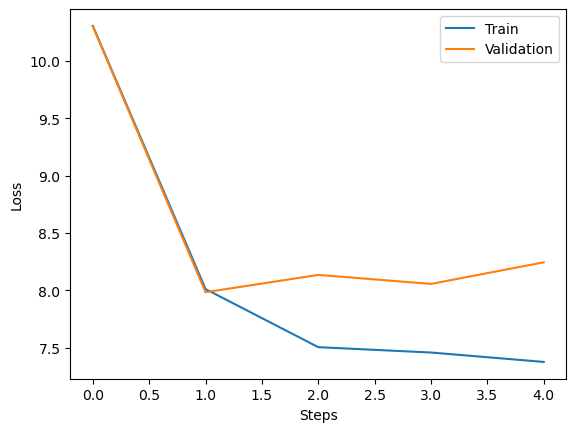

In [26]:
# Plot the losses
import matplotlib.pyplot as plt
plt.plot([l[0] for l in losses], label='Train')
plt.plot([l[1] for l in losses], label='Validation')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Example prompt
initial_words = ["House"]
context_ids = torch.tensor([ [word_to_idx[w] for w in initial_words] ], dtype=torch.long, device=device)

model.eval()
with torch.no_grad():
    generated_ids = model.generate(context_ids, max_new_tokens=20)

generated_words = [idx_to_word[i.item()] for i in generated_ids[0]]
generated_text = " ".join(generated_words)

print("Generated text:", generated_text)

Generated text: House consorted the fairest and a assistant as O appeared KING lives gentlemen pitying, thieves hither Have the torches on land,


This assignment provides a complete implementation of a GPT-style transformer language model trained on word-level data from Shakespeare's texts. Through examining each component—from attention heads to transformer blocks to the complete GPT architecture—we can understand how these models work from the ground up.


Key takeaways from this implementation:

- Attention Mechanism: The self-attention mechanism allows the model to focus on different parts of the input when making predictions, capturing relationships between words regardless of their distance in the text.
- Transformer Architecture: The combination of multi-head attention, feed-forward networks, residual connections, and layer normalization creates a powerful and trainable architecture for sequence modeling.
- Autoregressive Learning: The model is trained to predict the next word given previous words, which enables it to generate coherent text by repeatedly sampling from its learned distribution.
- Positional Information: Since transformers process all tokens in parallel, positional embeddings are essential to maintain sequence order information.
- Batched Training: The get_batch function efficiently samples training data, enabling effective learning from large text corpora.

Despite the relative simplicity of this implementation (compared to state-of-the-art models with billions of parameters), it demonstrates the core principles that underlie modern language models like GPT-4o, Gemini, and Claude. Even with limited training and a small model size, the implementation is able to learn patterns from Shakespeare's language and generate text with Shakespearean characteristics.

This provides valuable insights into how large language models work and serves as a foundation for understanding more complex implementations and innovations in the field of natural language processing.

There are some over-simplifications in this assignment that you might want to correct. For example, words are usually not used as tokens. Sub-word tokens obtained through strategies like BPE are generally a better unit. Try implementing the same language model with subword tokens. You can also alter the number of heads, the size of the dataset, or any other hyperparameter.

We have also not handled unknown tokens in our dataset. How would we change our code to handle this?